In [1]:
import numpy as np
import matplotlib.pyplot as plt

#____________________________________________________________

import pathlib
import tensorflow as tf
import cv2, os, random
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)

#____________________________________________________________

directory = r'C:\Users\riyag\OneDrive\Desktop\Industry project\dataset'

path_for_data = pathlib.Path(directory)

#____________________________________________________________

print("Required libraries were succesfully imported...")


Required libraries were succesfully imported...


In [2]:
batch_size = 25
img_height = 128
img_width = 128

In [3]:
train_df = image_dataset_from_directory(path_for_data,
                                        image_size = (128, 128),
                                        validation_split = 0.2,
                                        subset = "training",
                                        shuffle = True,
                                        batch_size = 25,
                                        seed = 123)

validation_df = image_dataset_from_directory(path_for_data,
                                             image_size = (128, 128),
                                             validation_split = 0.2,
                                             subset = "validation",
                                             shuffle = True,                                         
                                             batch_size = 25,
                                             seed = 123)

Found 17491 files belonging to 43 classes.
Using 13993 files for training.
Found 17491 files belonging to 43 classes.
Using 3498 files for validation.


In [4]:
train_df, validation_df

(<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [5]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 560 images in the training dataset
There is 140 images in the validation dataset


In [6]:
class_names = train_df.class_names
print(class_names)

['A10', 'A400M', 'AG600', 'AV8B', 'B1', 'B2', 'B52', 'Be200', 'C130', 'C17', 'C2', 'C5', 'E2', 'E7', 'EF2000', 'F117', 'F14', 'F15', 'F16', 'F18', 'F22', 'F35', 'F4', 'J20', 'JAS39', 'MQ9', 'Mig31', 'Mirage2000', 'P3', 'RQ4', 'Rafale', 'SR71', 'Su34', 'Su57', 'Tornado', 'Tu160', 'Tu95', 'U2', 'US2', 'V22', 'Vulcan', 'XB70', 'YF23']


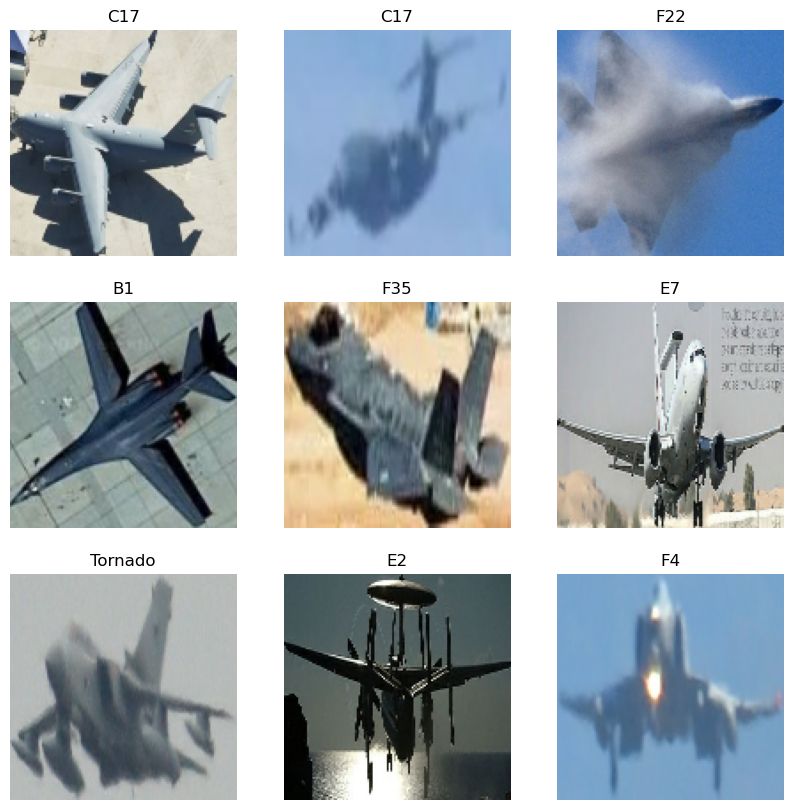

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_df:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(25, 128, 128, 3)
(25,)


# Data performance

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_df.cache().prefetch(buffer_size=AUTOTUNE)

# Standardisation of data

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_df.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


#  BASIC MODEL-CNN

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile Model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [21]:
epochs=5
history = model.fit(
  train_df,
  validation_data=validation_df,
  epochs=epochs
)

Epoch 1/5
560/560 [==============================] - 150s 264ms/step - loss: 2.8346 - accuracy: 0.2656 - val_loss: 3.0058 - val_accuracy: 0.2456
Epoch 2/5
560/560 [==============================] - 154s 273ms/step - loss: 2.2213 - accuracy: 0.4115 - val_loss: 2.9199 - val_accuracy: 0.2976
Epoch 3/5
560/560 [==============================] - 165s 293ms/step - loss: 1.5030 - accuracy: 0.5837 - val_loss: 3.2932 - val_accuracy: 0.3159
Epoch 4/5
560/560 [==============================] - 156s 278ms/step - loss: 0.8752 - accuracy: 0.7493 - val_loss: 4.0524 - val_accuracy: 0.3213
Epoch 5/5
560/560 [==============================] - 153s 272ms/step - loss: 0.5073 - accuracy: 0.8479 - val_loss: 4.9767 - val_accuracy: 0.3173


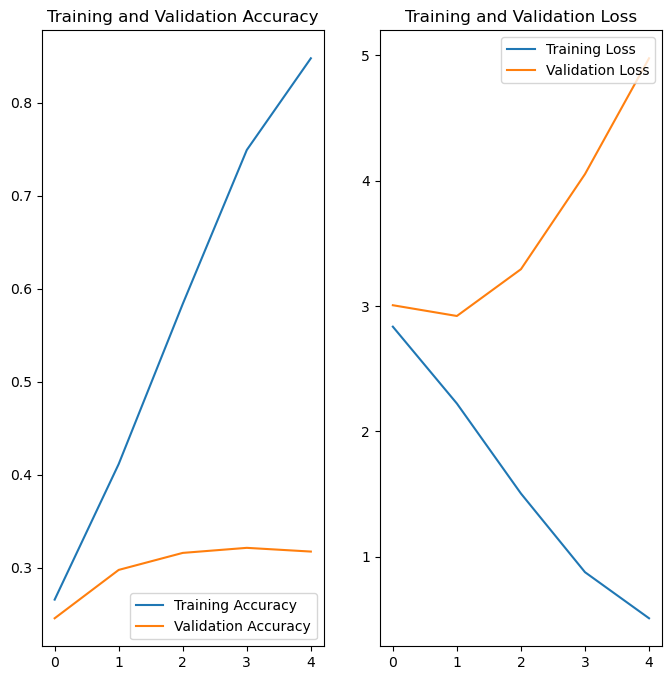

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data Augmentation

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

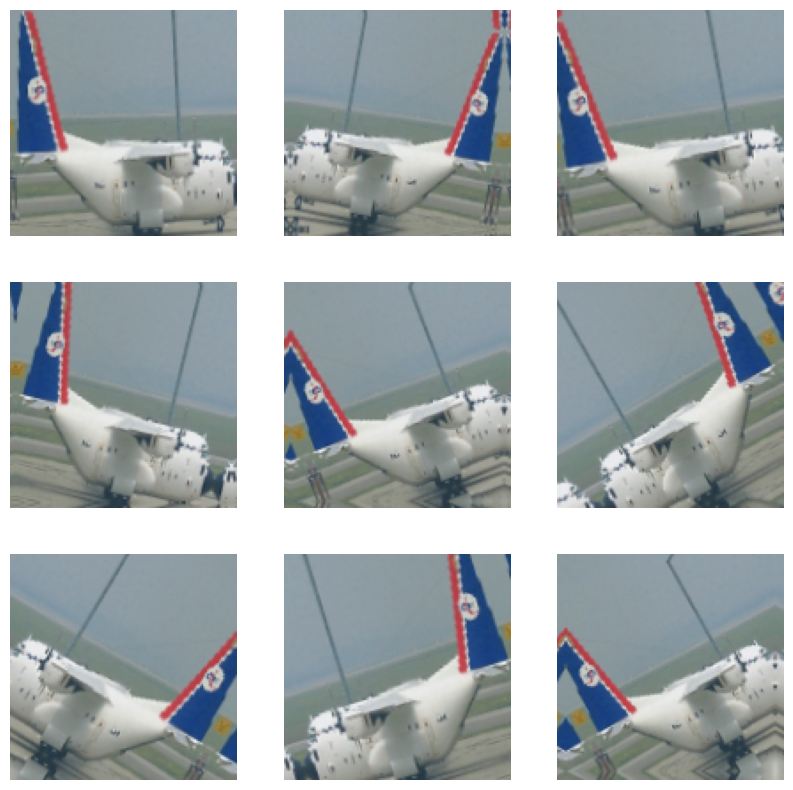

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_df.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# dropout

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
epochs = 5
history = model.fit(
  train_df,
  validation_data=validation_df,
  epochs=epochs
)


Epoch 1/5
560/560 [==============================] - 177s 304ms/step - loss: 3.6117 - accuracy: 0.0637 - val_loss: 3.5301 - val_accuracy: 0.0706
Epoch 2/5
560/560 [==============================] - 176s 313ms/step - loss: 3.4775 - accuracy: 0.0920 - val_loss: 3.3770 - val_accuracy: 0.1169
Epoch 3/5
560/560 [==============================] - 185s 329ms/step - loss: 3.3029 - accuracy: 0.1369 - val_loss: 3.2826 - val_accuracy: 0.1518
Epoch 4/5
560/560 [==============================] - 183s 325ms/step - loss: 3.1250 - accuracy: 0.1799 - val_loss: 3.1489 - val_accuracy: 0.1827
Epoch 5/5
560/560 [==============================] - 175s 312ms/step - loss: 2.9844 - accuracy: 0.2132 - val_loss: 3.0109 - val_accuracy: 0.2110


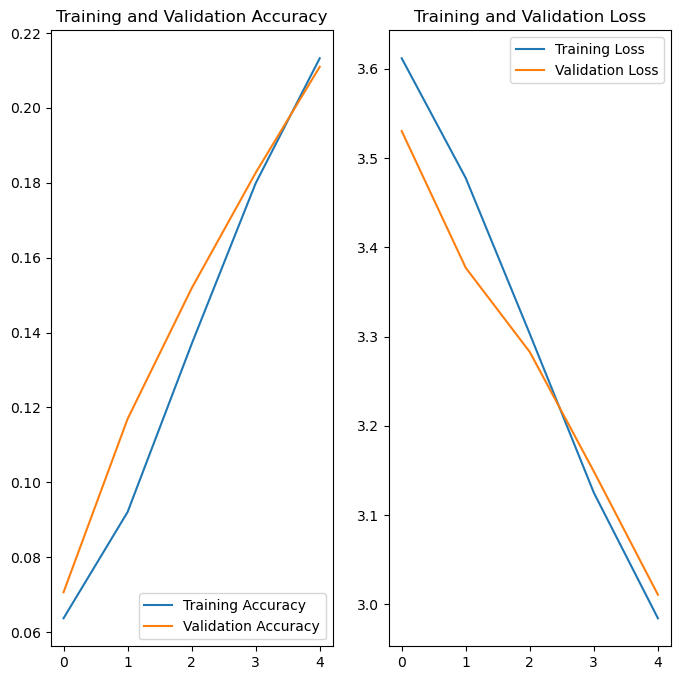

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Resnet50

In [29]:
image_size = (128, 128)
image_shape = image_size + (3,)
print(image_shape)

(128, 128, 3)


In [30]:
preprocess_input = applications.resnet50.preprocess_input

In [31]:
base_model = applications.ResNet50(input_shape = image_shape, include_top = False, weights = 'imagenet')

In [32]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [34]:
nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nclass, activation = 'softmax')

In [35]:
inputs = tf.keras.Input(shape = image_shape)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 43)                88107 

In [36]:
optimizer = optimizers.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [37]:
history = model.fit(train_df, validation_data = validation_df, epochs = 1)

560/560 [==============================] - 523s 926ms/step - loss: 2.6582 - accuracy: 0.3387 - val_loss: 2.1264 - val_accuracy: 0.4202


In [38]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [39]:
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [40]:
ft_epoch = 1
n_epochs =+ ft_epoch

history_fine = model.fit(train_df, validation_data = validation_df, epochs = n_epochs, initial_epoch = history.epoch[-1])

560/560 [==============================] - 1455s 3s/step - loss: 1.5520 - accuracy: 0.5813 - val_loss: 0.8488 - val_accuracy: 0.7587


# EfficientNetB3

In [13]:
image_size = (128, 128)
image_shape = image_size + (3,)
print(image_shape)

(128, 128, 3)


In [29]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [33]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= image_shape)

In [34]:
nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nclass, activation = 'softmax')

In [35]:
inputs = tf.keras.Input(shape = image_shape)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 4, 4, 1536)       10783535  
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 43)                66091     
                                                                 
Total params: 10,849,626
Trainable params: 10,762,323
Non-trainable params: 87,303
_________________________________________________________________


In [36]:
optimizer = optimizers.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [37]:
history = model.fit(train_df, validation_data = validation_df, epochs = 1)

560/560 [==============================] - 5182s 9s/step - loss: 1.7120 - accuracy: 0.5297 - val_loss: 0.9001 - val_accuracy: 0.7476


In [38]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [39]:
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [40]:
ft_epoch = 1
n_epochs =+ ft_epoch

history_fine = model.fit(train_df, validation_data = validation_df, epochs = n_epochs, initial_epoch = history.epoch[-1])

560/560 [==============================] - 1483s 3s/step - loss: 0.9149 - accuracy: 0.7377 - val_loss: 0.7246 - val_accuracy: 0.7993


# Making prediction from new data

In [72]:
plane_url = "https://i.ytimg.com/vi/xnOw3clRIoI/maxresdefault.jpg"
plane_path = tf.keras.utils.get_file('V-22 aircraft', origin=plane_url)

img = tf.keras.utils.load_img(
    plane_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}"
    .format(class_names[np.argmax(score)])
)

1/1 [==============================] - 0s 263ms/step
This image most likely belongs to V22


In [73]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\riyag\AppData\Local\Temp\tmps5gy0xkh\assets


INFO:tensorflow:Assets written to: C:\Users\riyag\AppData\Local\Temp\tmps5gy0xkh\assets


In [74]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [75]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['input_2'], 'outputs': ['dense_3']}}

In [76]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [78]:
predictions_lite = classify_lite(input_2=img_array)['dense_3']
score_lite = tf.nn.softmax(predictions_lite)

In [79]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to V22 with a 6.01 percent confidence.


In [80]:
print(np.max(np.abs(predictions - predictions_lite)))

1.839362e-08
